<a href="https://colab.research.google.com/github/MaribelLuque/SaturdaysAI/blob/master/Borrador_Proyecto_incendios.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prediction of forest fires using artificial intelligence

## About

###...Saturdays AI

Saturdays.AI is a non-profit in a mission to empower diverse individuals to learn Artificial Intelligence in a collaborative and project-based way, beyond the conventional education path.

During the first half of the program we learn the foundations of machine-learning and deep-learning by coding exercises on GPU enabled environments in a collaborative way, assisted by facilitators and mentors.

In the second half of the program, we build end2end AI powered prototypes using what we learnt on the "code2learn" phase, working with the dataset and model of our choice, we address a real problem with AI.

SaturdayAIFellows are committed to creating **positive social impact**, open source projects in exchange for their accessible education.

###...This project

Forest fires has become one of the biggest ecological problems suffered by our forests due to the high frequency and intensity it has acquired in recent years.

In Spain there is an annual average of 14,476 fires affecting 108,282.39 hectares of surface area (data from the last ten years 2005-2014). Fuente: Ministerio de Agricultura, Pesca y Alimentación.

The key is **prevention and early detection**. In this project we apply artificial intelligence to predict in real time the probability that fire will start, the intensity of the fire if it occurs and the measures, if any, that should be taken.

###...Our datasets

####*Fire information for resource management system (FIRMS)*
Summary elaborated by Rafa Sánchez
rafael.sanchez.duran@gmail.com

where to find https://firms.modaps.eosdis.nasa.gov/



NASA logo The Fire Information for Resource Management System (FIRMS) distributes Near Real-Time (NRT) active fire data within 3 hours of satellite observation from both the Moderate Resolution Imaging Spectroradiometer (MODIS) and the Visible Infrared Imaging Radiometer Suite (VIIRS).

The active fire / hotspot data can be viewed in FIRMS Fire Map or in NASA’s Worldview , delivered as email alerts or downloaded in the following formats: SHP, KML, TXT, WMS

FIRMS is part of NASA’s Land, Atmosphere Near real-time Capability for EOS (LANCE).


DATASETS:

Active Fire Data  
Download active fire products from the Moderate Resolution Imaging Spectroradiometer (MODIS) (MCD14DL) and Visible Infrared Imaging Radiometer Suite (VIIRS) 375 m (VNP14IMGTDL_NRT) for the last 24, 48 hours and 7 days in shapefile, KML, WMS or text file formats. VIIRS data complement MODIS fire detections but the improved spatial resolution of the 375 m data provides a greater response over fires of relatively small areas. Read more about VIIRS...
Data older than 7 days can be obtained from the Archive Download Tool. Users intending to perform scientific analysis are advised to download the standard (science quality) data.

Please note:

MODIS C6 is available from November 2000 (for Terra) and from July 2002 (for Aqua) to the present.
VIIRS 375 m data are currently available from 20 January 2012 to the present.

TXT https://earthdata.nasa.gov/earth-observation-data/near-real-time/firms/active-fire-data 

Download text files, in CSV format, for the last 24 and 48 hours, and 7 days.
Access daily text files for the last two months via HTTP: https://nrt4.modaps.eosdis.nasa.gov/archive/FIRMS

For MODIS C6 data go to: https://nrt4.modaps.eosdis.nasa.gov/archive/FIRMS/c6

For VIIRS 375m data go to: https://nrt4.modaps.eosdis.nasa.gov/archive/FIRMS/viirs

To keep file sizes to a minimum, the data are provided by region.

####*Climate information*

These data series come from a collection of images from the MODIS satellite (MOD IS/MCD43A4_006_NDVI). We obtain the NDVI (Index of Vegetation in Normarized Differences) and the LST (Land Surface Temperature) values for a specific data range and region of interest using the Google Earth Engine API. To get this collection of images it is necessary to have previously an active GEE account.


-------Maribel: Aquí añadiría alguna explicación de qué es el índice NDVI, qué representa y para qué sirve. Además la intensidad del viento y su dirección también son dos datos que si se pueden descargar de esta misma forma serían de vital utilidad para el modelo.

####*Wind speed and direction from wind turbines*

Wind energy in Spain is a renewable source of electricity in which Spain has been a pioneer.  With 23,484 MW of accumulated power, wind energy has been the second source of electricity generation in Spain in 2018. Spain is the fifth country in the world in terms of installed wind power, after China, the United States, Germany and India. 
In our country wind energy covers 19% of the energy consumed. There are currently 1,123 wind farms installed in 807 municipalities in Spain. 

This geographic scenario is ideal for the use of wind speed and direction records in each wind turbine as additional data for fire prediction.

For this purpose, we will use as a validation dataset for our predictive model, the data collected during the year 2018 from the 21 wind turbines of the PESUR wind farm (Tarifa, Cádiz) provided by Enel Green Power.

##Imports

In [0]:
#Instalamos los paquetes necesarios.
!pip install fastai==0.7.0
!pip install googledrivedownloader
!pip install utm

In [0]:
# Installing GEE API
!pip install earthengine-api

In [0]:
#Importamos las librerías
from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display

from sklearn import metrics

import pandas as pd
import os
import numpy as np
import utm
import matplotlib.pyplot as plt
import ee, datetime #GEE

##Read data

###Reading fire and wind turbine data from csv.

In [26]:
#Descargamos desde Google Drive los data sets
from google_drive_downloader import GoogleDriveDownloader as gdd
#El dataset de PESUR
gdd.download_file_from_google_drive(file_id='1RuwvvwU8giKIu3ARMsos5N0_19zrHxEj',
                                    dest_path='./data/datos_PESUR_21_2018EDIT.csv',
                                    unzip=False)

#El data set del histórico de incendios de la NASA
!mkdir './data/HISTORICO_NASA/'
gdd.download_file_from_google_drive(file_id='1nks6UP3aZXS2GqKjuj-qD2uFXVILTTwa',
                                    dest_path='./data/HISTORICO_NASA/fire_archive_V1_56830.csv',
                                    unzip=False)

mkdir: cannot create directory ‘./data/HISTORICO_NASA/’: File exists


In [4]:
#Descargamos los datos de los 7 últimos días de incendios de la NASA directamente desde el enlace en la web.
!mkdir './data/ACTUAL_NASA/'
PATH = 'data/ACTUAL_NASA/'
os.chdir (PATH)
!wget https://firms.modaps.eosdis.nasa.gov/data/active_fire/viirs/csv/VNP14IMGTDL_NRT_Europe_7d.csv

--2019-07-06 08:37:17--  https://firms.modaps.eosdis.nasa.gov/data/active_fire/viirs/csv/VNP14IMGTDL_NRT_Europe_7d.csv
Resolving firms.modaps.eosdis.nasa.gov (firms.modaps.eosdis.nasa.gov)... 198.118.194.34, 2001:4d0:241a:40c0::34
Connecting to firms.modaps.eosdis.nasa.gov (firms.modaps.eosdis.nasa.gov)|198.118.194.34|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 618859 (604K) [text/csv]
Saving to: ‘VNP14IMGTDL_NRT_Europe_7d.csv’

VNP14IMGTDL_NRT_Eur 100%[===================>] 604.35K  --.-KB/s    in 0.06s   

2019-07-06 08:37:17 (10.2 MB/s) - ‘VNP14IMGTDL_NRT_Europe_7d.csv’ saved [618859/618859]



In [5]:
#Creamos el dataframe de los datos de PESUR.
#Forzamos a que el campo "Fecha" lo importe con el type datetime
os.chdir('/content')
!pwd 
df_pesur = pd.read_csv('./data/datos_PESUR_21_2018EDIT.csv', low_memory=False, parse_dates=["Fecha"]) 

#Vemos el tipo de datos
df_pesur.info()

/content
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52222 entries, 0 to 52221
Data columns (total 6 columns):
Numero_de_serie           52222 non-null int64
Fecha                     52222 non-null datetime64[ns]
Velocidad_de_viento       52222 non-null float64
Posicion_de_la_gondola    52222 non-null int64
Latitud                   52222 non-null float64
Longitud                  52222 non-null float64
dtypes: datetime64[ns](1), float64(3), int64(2)
memory usage: 2.4 MB


In [6]:
#Creamos el dataframe de los datos HISTÓRICOS DE INCENDIOS.
#Forzamos a que el campo "Fecha y hora de adquisición" lo importe con el type datetime
df_hist = pd.read_csv('./data/HISTORICO_NASA/fire_archive_V1_56830.csv', low_memory=False, parse_dates=["acq_date_time"])

#Vemos el tipo de datos
df_hist.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105700 entries, 0 to 105699
Data columns (total 13 columns):
latitude         105700 non-null float64
longitude        105700 non-null float64
bright_ti4       105700 non-null float64
scan             105700 non-null float64
track            105700 non-null float64
satellite        105700 non-null object
instrument       105700 non-null object
confidence       105700 non-null object
version          105700 non-null int64
bright_ti5       105700 non-null float64
frp              105700 non-null float64
type             105700 non-null int64
acq_date_time    105700 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(7), int64(2), object(3)
memory usage: 10.5+ MB


In [7]:
#Creamos el dataframe de los datos HISTÓRICOS DE INCENDIOS.
#Forzamos a que el campo "Fecha y hora de adquisición" lo importe con el type datetime
df_actual = pd.read_csv('./data/ACTUAL_NASA/VNP14IMGTDL_NRT_Europe_7d.csv', low_memory=False, parse_dates=["acq_date"]) 

#Vemos el tipo de datos
df_actual.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7997 entries, 0 to 7996
Data columns (total 13 columns):
latitude      7997 non-null float64
longitude     7997 non-null float64
bright_ti4    7997 non-null float64
scan          7997 non-null float64
track         7997 non-null float64
acq_date      7997 non-null datetime64[ns]
acq_time      7997 non-null int64
satellite     7997 non-null object
confidence    7997 non-null object
version       7997 non-null object
bright_ti5    7997 non-null float64
frp           7997 non-null float64
daynight      7997 non-null object
dtypes: datetime64[ns](1), float64(7), int64(1), object(4)
memory usage: 812.3+ KB


###Reading NDVI and LST from GEE API

In [28]:
# Getting the access token to GEE API
!earthengine authenticate
# Initalization of Google Earth Engine API
ee.Initialize()

Running command using Cloud API.  Set --no-use_cloud_api to go back to using the API
Opening the following address in a web browser:

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code

Please authorize access to your Earth Engine account, and paste the generated code below. If the web browser does not start, please manually browse the URL above.

Please enter authorization code: 4/fgE20SFz_dHWgOdgGZ2Hv9uq_-jaC6MNVC78C2HMFVyfM46X6HcuAow

Successfully saved authorization token.


In [0]:
def  NDVI2DF(coordinates, region, date_start, end_date):
  #Get the NDVI (Normalised Difference Vegetation Index) from MODIS Satellite via Google Earth Engine
  #coordinates : array of coordinates long/lat
  #region : polygon or point values
  #date_start : Starting Date for setup date range
  #end_date : Ending Date for setup date range 
  #Define the type of geometry for setting properly the region coordinates
  
  if region == 'polygon' :
      ROI = ee.Geometry.Polygon(coordinates)
  elif region == 'point' :  
      ROI = ee.Geometry.Point(coordinates)
  else:
      raise KeyError('Wrong region value, allowed values are polygon or point')


  # Define the image (scala 1000)
  img = ee.ImageCollection('MODIS/MCD43A4_006_NDVI').filterDate(date_start, end_date)
  result = img.select('NDVI').getRegion(ROI,1000).getInfo()


  # Export to dataframe
  df_NDVI = pd.DataFrame(result[1:])
  df_NDVI.columns = result[0]
  
  return df_NDVI

In [0]:
# Main Program Code to call function NDVI2DF

# Gettting Date Range
date_start = ee.Date('2019-03-01')
end_date = ee.Date('2019-06-30')

# Setting type of geometry for region of interest (point or polygon)
region = 'point'

# Getting ROI through array of coordinates (point of polygon)
coordinates = [6.134136, 49.612485]
#coordinates = [[-6.151065585896504, 36.29423686205435],
#          [-6.035709140584004, 36.19012306037972],
#          [-5.601749179646504, 36.00370222379312],
#          [-5.313358066365254, 36.21228654591974],
#          [-5.516605136677754, 36.87866023265441],
#          [-6.428470371052754, 36.73131853399765]]

df_NDVI = NDVI2DF (coordinates, region, date_start, end_date)
df_NDVI

In [0]:
def  LST2DF(coordinates, region, date_start, end_date):
  #Get the LST (Land Surface Temperature) from MODIS Satellite via Google Earth Engine
  #coordinates : array of coordinates long/lat
  #region : polygon or point values
  #date_start : Starting Date for setup date range
  #end_date : Ending Date for setup date range 
  # Define the type of geometry for setting properly the region coordinates
  
  if region == 'polygon' :
      ROI = ee.Geometry.Polygon(coordinates)
  elif region == 'point' :  
      ROI = ee.Geometry.Point(coordinates)
  else:
      raise KeyError('Wrong region value, allowed values are polygon or point')

  # Define the image (scala 1000)
  img = ee.ImageCollection('MODIS/006/MOD11A2').filterDate(date_start, end_date)
  result = img.select('LST_Day_1km').getRegion(ROI,1000).getInfo()

  # Export to dataframe
  df_LST = pd.DataFrame(result[1:])
  df_LST.columns = result[0]
  
  # Switching LST from Kelvin to Celsius
  df_LST['LST_Celsius'] = df_LST.groupby(['id']).transform(sum)['LST_Day_1km'] * 0.02-273.15
   
  
  return df_LST


In [33]:
# Main Program Code to call function NDVI2DF

# Gettting Date Range
date_start = ee.Date('2019-03-01')
end_date = ee.Date('2019-06-30')

# Setting type of geometry for region of interest (point or polygon)
region = 'point'

# Getting ROI through array of coordinates (point of polygon)
coordinates = [6.134136, 49.612485]
#coordinates = [[-6.151065585896504, 36.29423686205435],
#          [-6.035709140584004, 36.19012306037972],
#          [-5.601749179646504, 36.00370222379312],
#          [-5.313358066365254, 36.21228654591974],
#          [-5.516605136677754, 36.87866023265441],
#          [-6.428470371052754, 36.73131853399765]]

df_LST = LST2DF (coordinates, region, date_start, end_date)
df_LST

,id,longitude,latitude,time,LST_Day_1km,LST_Celsius
0,2019_03_06,6.131002,49.609462,1551830400000,14186,10.57
1,2019_03_14,6.131002,49.609462,1552521600000,14512,17.09
2,2019_03_22,6.131002,49.609462,1553212800000,14500,16.85
3,2019_03_30,6.131002,49.609462,1553904000000,14697,20.79
4,2019_04_07,6.131002,49.609462,1554595200000,14547,17.79
5,2019_04_15,6.131002,49.609462,1555286400000,14957,25.99
6,2019_04_23,6.131002,49.609462,1555977600000,14835,23.55
7,2019_05_01,6.131002,49.609462,1556668800000,14993,26.71
8,2019_05_09,6.131002,49.609462,1557360000000,14728,21.41
9,2019_05_17,6.131002,49.609462,1558051200000,15177,30.39


###Reading wind, humidity and xxx from AEMET Open source

##Look at the data

In [0]:
#Definimos la función "display all" que nos va a servir después para ver los datos. 

def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [9]:
#Vemos los datos del dataframe de PESUR cómo es
display_all(df_pesur)

,Numero_de_serie,Fecha,Velocidad_de_viento,Posicion_de_la_gondola,Latitud,Longitud
0,781978,2018-01-01 00:00:00,7.0,303,36.045217,-5.589723
1,781978,2018-01-01 00:10:00,9.3,307,36.045217,-5.589723
2,781978,2018-01-01 00:20:00,8.5,309,36.045217,-5.589723
3,781978,2018-01-01 00:30:00,7.9,318,36.045217,-5.589723
4,781978,2018-01-01 00:40:00,7.0,318,36.045217,-5.589723
5,781978,2018-01-01 00:50:00,7.1,322,36.045217,-5.589723
6,781978,2018-01-01 01:00:00,6.8,324,36.045217,-5.589723
7,781978,2018-01-01 01:10:00,6.3,325,36.045217,-5.589723
8,781978,2018-01-01 01:20:00,6.4,327,36.045217,-5.589723
9,781978,2018-01-01 01:30:00,6.2,326,36.045217,-5.589723


In [10]:
#Vemos los datos del dataframe del histórico de incendios cómo es
display_all(df_hist)

,latitude,longitude,bright_ti4,scan,track,satellite,instrument,confidence,version,bright_ti5,frp,type,acq_date_time
0,37.79222,-5.13807,345.0,0.34,0.56,N,VIIRS,n,1,275.8,4.7,0,2012-01-20 02:55:00
1,42.52013,-0.10170,335.0,0.44,0.39,N,VIIRS,n,1,287.1,12.5,0,2012-01-20 12:37:00
2,41.31446,1.66437,308.9,0.35,0.56,N,VIIRS,n,1,270.8,1.1,2,2012-01-21 02:35:00
3,39.93512,-3.74576,299.1,0.41,0.45,N,VIIRS,n,1,273.6,0.9,2,2012-01-21 02:36:00
4,40.24698,-3.47210,297.8,0.41,0.45,N,VIIRS,n,1,272.4,0.8,2,2012-01-21 02:36:00
5,40.24296,-3.47358,307.4,0.41,0.45,N,VIIRS,n,1,272.6,0.8,2,2012-01-21 02:36:00
6,38.32217,-6.71537,312.5,0.48,0.40,N,VIIRS,n,1,278.2,1.5,2,2012-01-21 02:37:00
7,37.23584,-6.77904,326.1,0.68,0.74,N,VIIRS,n,1,287.3,2.6,0,2012-01-21 12:18:00
8,37.23883,-6.77922,343.5,0.50,0.49,N,VIIRS,n,1,287.5,4.2,0,2012-01-21 13:58:00
9,39.03726,-6.98222,326.6,0.51,0.50,N,VIIRS,n,1,288.1,4.9,0,2012-01-21 13:58:00


In [11]:
#Vemos los datos del dataframe del histórico de incendios cómo es
display_all(df_actual)

,latitude,longitude,bright_ti4,scan,track,acq_date,acq_time,satellite,confidence,version,bright_ti5,frp,daynight
0,41.26551,31.42133,300.2,0.56,0.52,2019-06-29,30,N,nominal,1.0NRT,280.4,1.1,N
1,42.71446,24.17389,338.5,0.41,0.37,2019-06-29,30,N,nominal,1.0NRT,288.9,3.7,N
2,42.71621,24.16412,300.9,0.41,0.37,2019-06-29,30,N,nominal,1.0NRT,285.5,1.7,N
3,42.58906,23.10545,295.4,0.39,0.36,2019-06-29,30,N,nominal,1.0NRT,284.0,1.1,N
4,42.06047,24.81129,301.0,0.43,0.38,2019-06-29,30,N,nominal,1.0NRT,289.7,0.9,N
5,39.71860,34.32637,315.0,0.43,0.62,2019-06-29,30,N,nominal,1.0NRT,285.9,1.9,N
6,39.71672,34.32434,315.6,0.43,0.62,2019-06-29,30,N,nominal,1.0NRT,286.3,1.9,N
7,43.79076,4.44480,319.5,0.66,0.73,2019-06-29,30,N,nominal,1.0NRT,296.8,4.4,N
8,39.94334,33.19114,297.3,0.37,0.58,2019-06-29,30,N,nominal,1.0NRT,286.3,0.8,N
9,42.45919,20.90844,295.6,0.39,0.36,2019-06-29,30,N,nominal,1.0NRT,282.7,0.4,N


In [12]:
#Función tail para mostrar las últimas entradas de datos
display_all(df_pesur.tail())

,Numero_de_serie,Fecha,Velocidad_de_viento,Posicion_de_la_gondola,Latitud,Longitud
52217,781978,2018-12-31 22:50:00,13.7,92,36.045217,-5.589723
52218,781978,2018-12-31 23:00:00,14.3,92,36.045217,-5.589723
52219,781978,2018-12-31 23:10:00,14.1,94,36.045217,-5.589723
52220,781978,2018-12-31 23:20:00,14.1,94,36.045217,-5.589723
52221,781978,2018-12-31 23:30:00,14.0,94,36.045217,-5.589723


In [13]:
#Función tail para mostrar las últimas entradas de datos
display_all(df_hist.tail())

,latitude,longitude,bright_ti4,scan,track,satellite,instrument,confidence,version,bright_ti5,frp,type,acq_date_time
105695,43.53809,-5.83013,342.6,0.39,0.36,N,VIIRS,n,1,286.8,11.0,2,2018-12-31 13:10:00
105696,43.12484,-6.38784,334.7,0.40,0.37,N,VIIRS,n,1,290.0,4.7,0,2018-12-31 13:10:00
105697,42.32085,-1.78886,325.5,0.41,0.37,N,VIIRS,n,1,285.4,1.8,0,2018-12-31 13:10:00
105698,43.52415,-5.73295,336.9,0.39,0.36,N,VIIRS,n,1,287.6,3.8,2,2018-12-31 13:10:00
105699,43.12572,-6.38267,328.6,0.40,0.37,N,VIIRS,n,1,288.0,4.3,0,2018-12-31 13:10:00


In [14]:
#Vemos alguna información estadística de cómo son nuestros datos
display_all(df_hist.describe(include='all').T)

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
latitude,105700,NaN,NaN,NaN,NaN,NaN,40.6353,2.76681,27.7241,38.8276,41.4529,42.9811,43.7095
longitude,105700,NaN,NaN,NaN,NaN,NaN,-4.38697,3.26609,-18.1504,-6.23711,-5.3497,-1.90458,4.26278
bright_ti4,105700,NaN,NaN,NaN,NaN,NaN,324.197,20.8,208,304.1,326.7,339.5,367
scan,105700,NaN,NaN,NaN,NaN,NaN,0.459929,0.0905928,0.32,0.39,0.43,0.51,0.8
track,105700,NaN,NaN,NaN,NaN,NaN,0.485535,0.119283,0.36,0.38,0.45,0.57,0.78
satellite,105700,1,N,105700,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
instrument,105700,1,VIIRS,105700,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
confidence,105700,3,n,95945,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
version,105700,NaN,NaN,NaN,NaN,NaN,1,0,1,1,1,1,1
bright_ti5,105700,NaN,NaN,NaN,NaN,NaN,290.809,12.5124,232.8,283.1,289.1,297.2,380


---------------Maribel: Aquí tenemos que incluir la parte de las gráficas que está preparando Rafa.

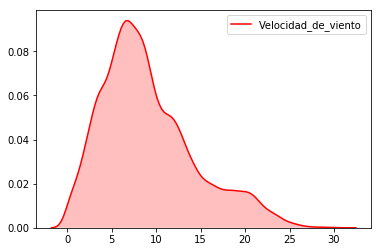

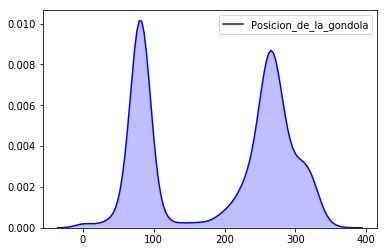

In [15]:
# Representamos con kdeplot()la aproximación continua a la distribución de densidad de datos de velocidad y dirección del viento
sns.kdeplot(df_pesur['Velocidad_de_viento'],shade=True, color="r")
plt.show()
sns.kdeplot(df_pesur['Posicion_de_la_gondola'], shade=True, color="b",)
plt.show()

##Pre-processing

In [0]:
#Bucle para redondear la fecha y hora de adquisición de los datos de histórico de incendios a los 10 minutos más próximos. 
print("Comienzo")
acq_date_time_redon = []
for i in range(df_hist.shape[0]):
    tm=df_hist.acq_date_time[i]
    discard = datetime.timedelta(minutes=tm.minute % 10, 
          seconds=tm.second, 
          microseconds=tm.microsecond) 
    tm -= discard 
    if discard >= datetime.timedelta(minutes=5): 
        tm += datetime.timedelta(minutes=10)
    acq_date_time_redon.append(tm)
print("Final")

In [0]:
#Convierto la lista anterior a un dataframe y lo anexo como columna adicional al dataframe de historico de incendios
df=pd.DataFrame(acq_date_time_redon, columns=['acq_date_time_redon'])
df_hist = df_hist.join(df)

In [0]:
#Vemos que se ha creado correctamente esta nueva columna
df_hist.info()

In [0]:
#Vemos los datos para comprobar que el redondeo se ha hecho correctamente
display_all(df_hist)

In [0]:
#Redondeamos los campos de latitud y longitud en los dos dataframes para poder hacerlos coincidir
df_hist=df_hist.round({'latitude': 0, 'longitude': 0})
df_pesur=df_pesur.round({'Latitud': 0, 'Longitud': 0})

In [0]:
#Vemos los primeros datos
df_pesur.head()

In [0]:
df_hist.head()

In [0]:
#Unimos los dos dataframes para crear un dataframe único para poder incorporar al modelo de RandomForest
#Esto es solo una prueba. La idea es unir los dataframes de histórico de incendios y climatológicos
df_hist.merge(df_pesur,left_on=['latitude','longitude','acq_date_time_redon'],right_on=['Latitud','Longitud','Fecha'],validate='m:1')

##Models

###Random Forests